
# Física computacional: Tarea 3

Profesor: Pablo Benítez Llambay

Integrantes:
- Martín Raguileo Reyes
- Fernando Zamora Carrasco


#### **IMPORTANTE EJECUTAR ESTA CELDA PARA QUE SE EJECUTE EL CÓDIGO SIN PROBLEMAS**

In [1]:
import importlib
import subprocess
import sys

def install_if_missing(package, name=None):
    name = name or package
    try:
        importlib.import_module(package)
        print(f"'{package} ya está instalado.")
    except ImportError:
        print(f"Instalando '{package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

packages = {
    "numpy": "numpy",
    "scipy": "scipy",
    "matplotlib": "matplotlib",
    "IPython": "ipython",
    "mpi4py": "mpi4py",
    "numba": "numba"
}

for pkg, name in packages.items():
    install_if_missing(pkg, name)

'numpy ya está instalado.
'scipy ya está instalado.
'matplotlib ya está instalado.
'IPython ya está instalado.
'mpi4py ya está instalado.
'numba ya está instalado.


In [2]:
import os
import shutil
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from mpi4py import MPI
import multiprocessing as mp
import numba

from matplotlib.artist import Artist
from numpy.typing import NDArray
from typing import Callable, List, Dict, Tuple, Optional
from IPython.display import Video, display, HTML, Math, Latex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introducción

## Marco Teórico

Considere una región cuadrada en 2D libre de carga, definida por una grilla de $N \times N$ puntos. El potencial eléctrico $V(x, y)$ en el interior satisface la Ecuación de Laplace:

\begin{equation}
    \nabla^2 V(x, y) = 0
\end{equation}

Las condiciones de borde son las siguientes:
- Pared superior: ($y = L$): $\,$ $V(x, L) = 100 \, V$
- Pared inferior: ($y = 0$): $\,$ $V(x, 0) = 0 \, V$
- Pared izquierda: ($x = 0$): $\,$ $V(0, y) = 0 \, V$
- Pared derecha: ($x = L$): $\,$ $V(L, y) = 0 \, V$

## 1. Implementación del solver estocástico

#### Función de la caminata aleatoria.

In [3]:
def randomWalk_Laplace(args: Tuple[int, int, int, int]) -> float:
    """
    Estima el potencial V en una posición (i, j) usando Random Walk.
    
    Argumentos (empaquetados en una tupla para compatibilidad futura con multiprocessing):
    args: tupla (i, j, N, M)
        i, j: Coordenadas iniciales en la grilla (enteros)
        N: Tamaño de la grilla (NxN)
        M: Número de caminantes a simular
        
    Retorna:
    V_ij: El potencial estimado en el punto (i, j)
    """
    i_start, j_start, N, M = args


    # Si el punto ya está en el borde, retornamos su valor conocido.
    # Asumimos que los índices van de 0 a N-1.
    # Pared Superior (fila 0 en matriz visual, o fila N-1 dependiendo de tu sistema de coord).
    # Vamos a usar la convención matricial: 
    # i=0 (arriba), i=N-1 (abajo), j=0 (izquierda), j=N-1 (derecha).
    # Entonces:

    # Pared superior (y=L -> i=0) -> V=100
    if i_start == 0:
        return 100.0
    # Pared inferior (y=0 -> i=N-1) -> V=0
    if i_start == N - 1:
        return 0.0
    # Pared izquierda (x=0 -> j=0) -> V=0
    if j_start == 0:
        return 0.0
    # Pared derecha (x=L -> j=N-1) -> V=0
    if j_start == N - 1:
        return 0.0
    
    potencial_acumulado = 0.0

    # Definir los movimientos posibles: arriba, abajo, izquierda, derecha.
    # Moverse hacia abajo y hacia la derecha incrementa los índices.
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # (delta_i, delta_j)

    for _ in range(M):
        # Iniciar la caminata en (i_start, j_start)
        curr_i, curr_j = i_start, j_start

        while True:
            # Elegir un movimiento aleatorio
            move = random.choice(moves)
            curr_i += move[0]
            curr_j += move[1]

            # Verificar si hemos alcanzado el borde

            # Pared superior (i=0) -> 100V
            if curr_i <= 0:
                potencial_acumulado += 100.0
                break

            # Pared inferior (i=N-1) -> 0V
            if curr_i >= N-1:
                potencial_acumulado += 0.0
                break

            # Pared izquierda (j=0) -> 0V
            if curr_j <= 0:
                potencial_acumulado += 0.0
                break

            # Pared derecha (j=N-1) -> 0V
            if curr_j >= N-1:
                potencial_acumulado += 0.0
                break

    V_ij = potencial_acumulado / M
    return V_ij

#### Simulación con caminata aleatoria para resolver la ecuación de Laplace en 2D.

In [4]:
def RW_Laplace_Simulation(N: int, M: int)  -> Tuple[NDArray[np.float64], float]:
    # Inicializar la matriz de potencial
    V = np.zeros((N, N))

    # Establecer condiciones de borde en la matriz
    V[0, :] = 100.0 # Pared superior

    # Bucle principal de la simulación
    start_time = time.time()

    # Iteramos solo sobre los puntos interiores
    for i in range(1, N-1):
        for j in range(1, N-1):
            # Preparamos los argumentos
            args = (i, j, N, M)

            # Llamamos a la función de caminata aleatoria
            val = randomWalk_Laplace(args)

            # Guardamos el resultado
            V[i, j] = val

    end_time = time.time()
    T_1 = end_time - start_time

    return (V, T_1)

In [5]:
## Definir los parámetros de la simluación
N = 50
M = 1_000

print("Iniciando simulación serial de Laplace (Random Walk)...")
print(f"Grilla: {N}x{N} | Cantidad de caminantes por punto: {M}")

# Llamamos a la función de la simulación
V, T_1 = RW_Laplace_Simulation(N, M)

print("\nSimulación completada.")
print(f"Tiempo de ejecución serial (T_1): {T_1:4f} segundos ({T_1/60:.4f} minutos).")

Iniciando simulación serial de Laplace (Random Walk)...
Grilla: 50x50 | Cantidad de caminantes por punto: 1000

Simulación completada.
Tiempo de ejecución serial (T_1): 195.022241 segundos (3.2504 minutos).


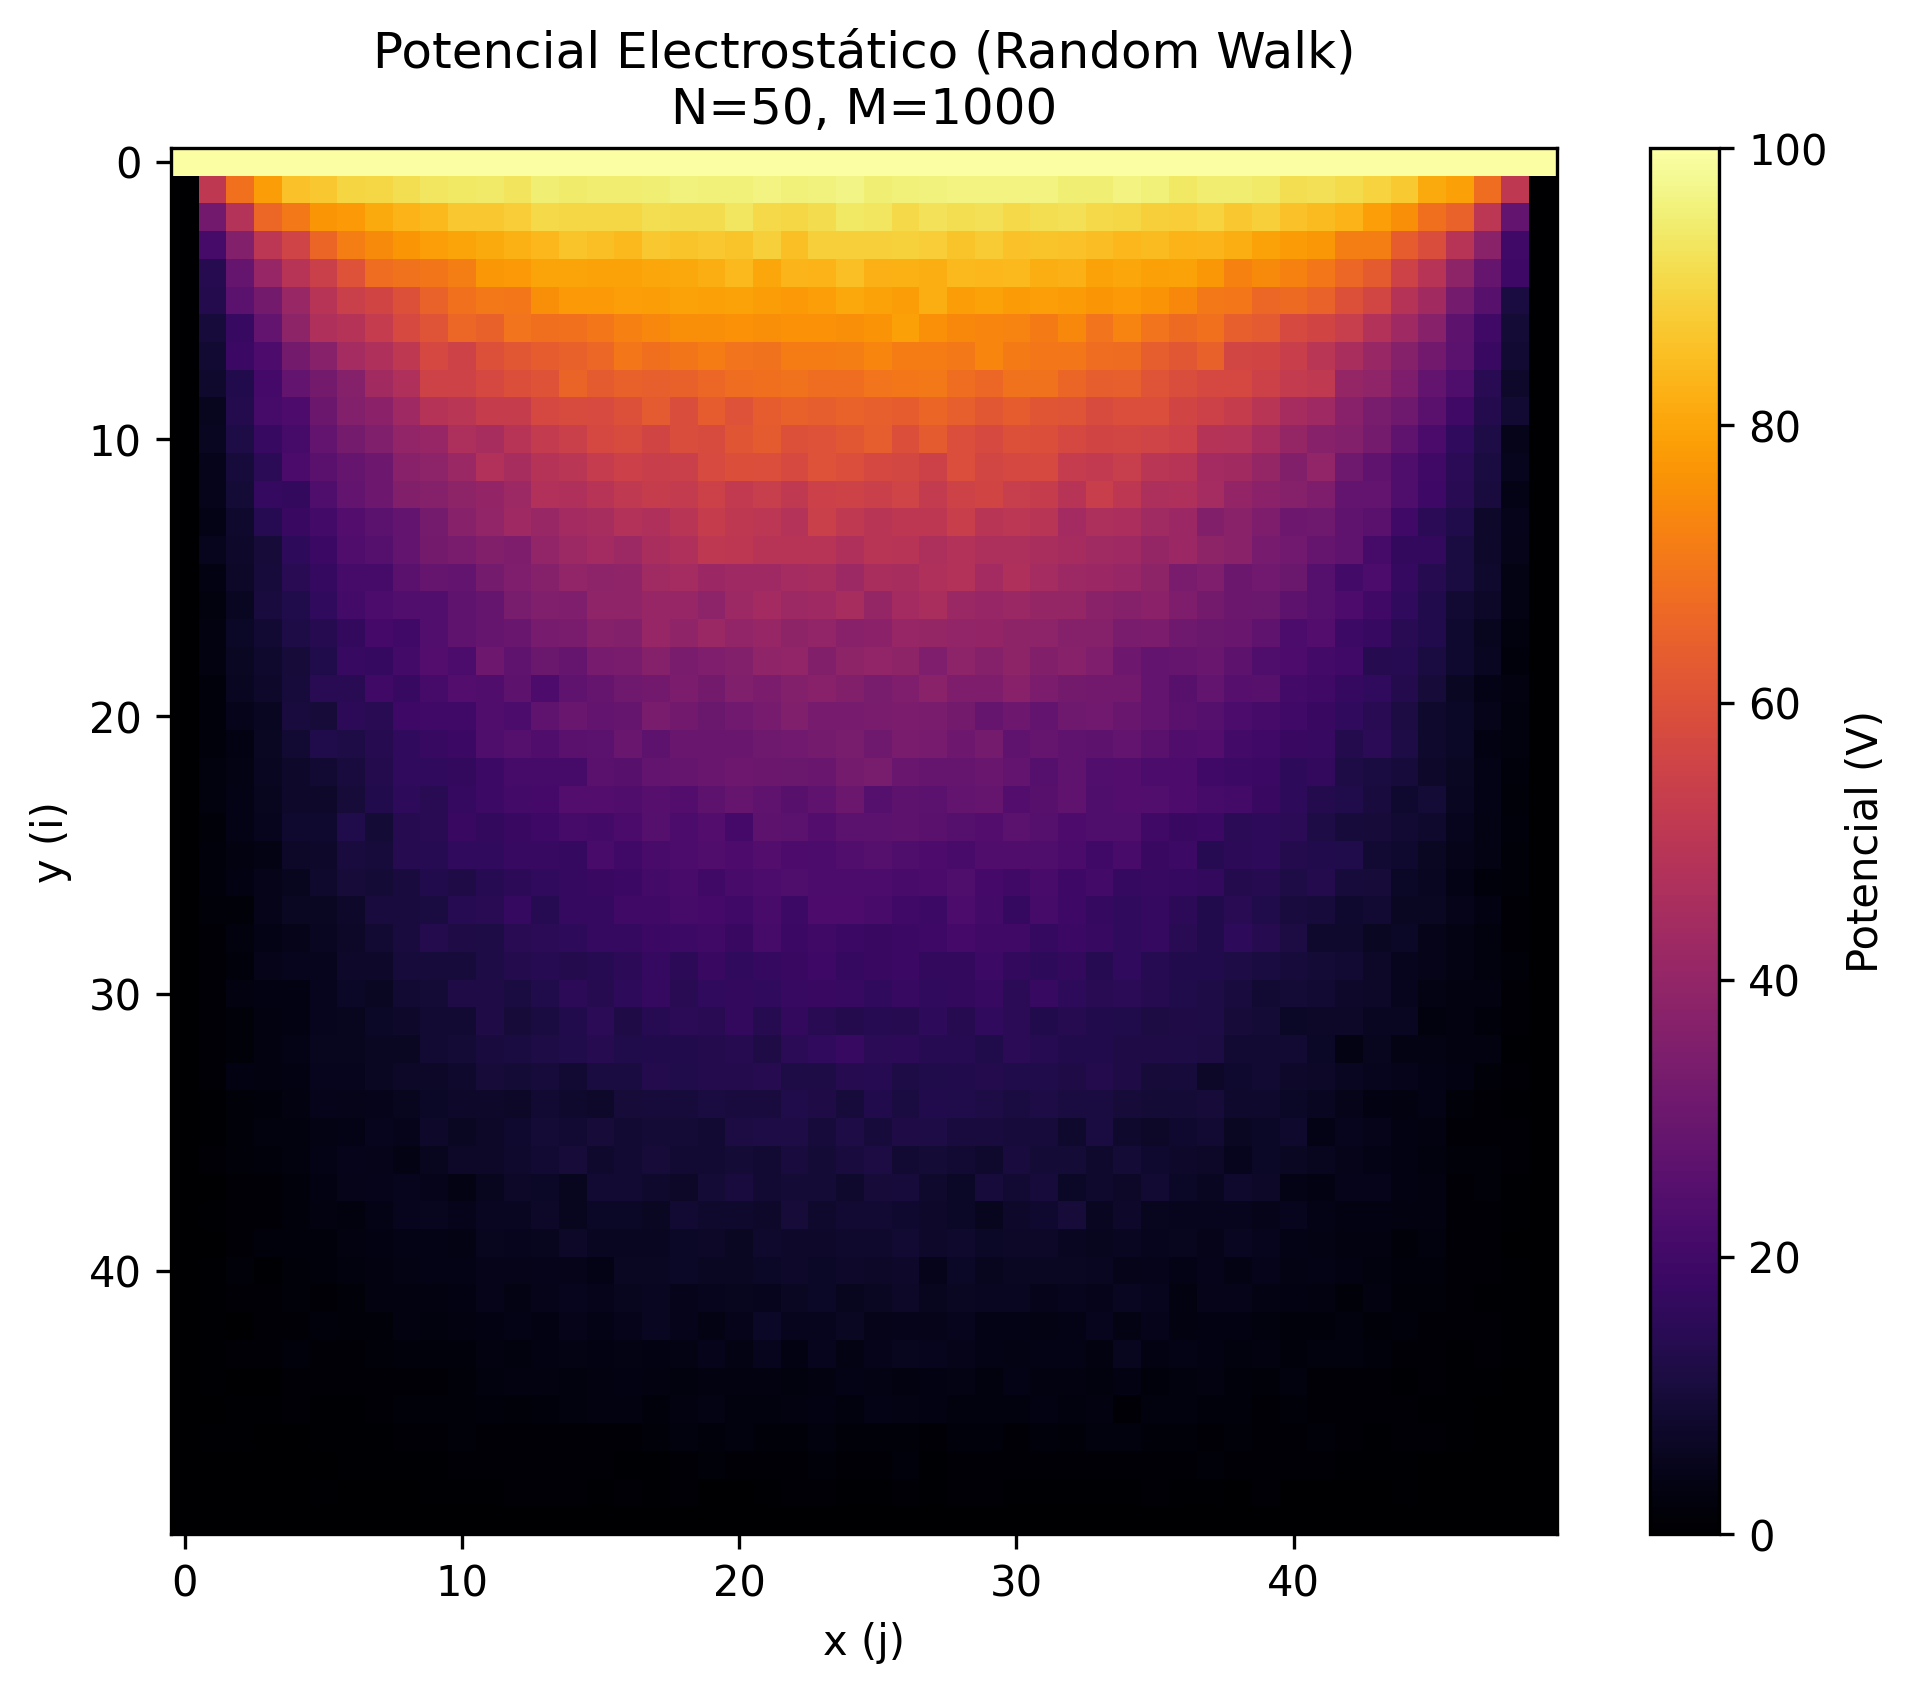

In [6]:
plt.figure(figsize=(8, 6), dpi=150)
plt.imshow(V, cmap='inferno', origin='upper')
plt.colorbar(label='Potencial (V)')
plt.title(f'Potencial Electrostático (Random Walk)\nN={N}, M={M}')
plt.xlabel('x (j)')
plt.ylabel('y (i)')
plt.show()

#### Animación del proceso de convergencia.

In [7]:
def convergence_animation(N: int, lista_M: List[int],
                          output_filename: str = "convergencia_laplace.mp4") -> str | None:
    """
    Genera una animación mostrando la solución para diferentes valores de M.
    
    Argumentos:
    - N: Tamaño de la grilla.
    - lista_M: Lista de enteros con los valores de M a simular (ej. [10, 50, 100]).
    - randomWalk_func: Tu función 'randomWalk_Laplace'.
    - output_filename: Nombre del archivo de salida.
    """

    # Preparamos el directorio
    output_dir = './media'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)

    print(f"Creando animación para N={N}")
    frames = []

    # Generar los datos para cada cuadro (M)
    for idx, M in enumerate(lista_M):
        print(f"Simulado cuadro {idx+1}/{len(lista_M)} para M={M}")
        V_M, T_M = RW_Laplace_Simulation(N, M)
        frames.append(V_M)

    print("\nGenerando video...")

    # Configuración de la animación
    fig, ax = plt.subplots(figsize=(8, 7))

    # Escala de colores fija (0V a 100V)
    cax = ax.imshow(frames[0], cmap='inferno', origin='upper', vmin=0, vmax=100)
    cbar = fig.colorbar(cax, ax=ax, label='Potencial (V)')

    title = ax.set_title(f"Convergencia Random Walk\nN={N}, M={lista_M[0]}, T={T_M} [s]")
    ax.set_xlabel('x (j)')
    ax.set_ylabel('y (i)')

    # Función de actualización de la animación
    def update(frame_idx) -> List:
        V_data = frames[frame_idx]
        M_val = lista_M[frame_idx]

        cax.set_data(V_data)
        title.set_text(f"Convergencia Random Walk\nN={N}, Caminantes M={M_val}")
        return [cax, title]
    
    # Crear animación
    # fps=1 para apreciar el cambio
    anim = animation.FuncAnimation(fig, update, frames=len(lista_M),
                                   interval=1000, blit=True)
    
    try:
        anim.save(output_path, writer='ffmpeg', fps=1, dpi=150)
        print(f"Animación guardada exitosamente en: {output_path}")
    except Exception as e:
        print(f"Error al guardar animación: {e}")
        return None

    plt.close(fig)
    return output_path

In [8]:
N_anim = 50
M_vals = [10, 50, 100, 200, 500, 1_000]
# M_vals = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000]

video_path = convergence_animation(N_anim, M_vals)

Creando animación para N=50
Simulado cuadro 1/6 para M=10
Simulado cuadro 2/6 para M=50
Simulado cuadro 3/6 para M=100
Simulado cuadro 4/6 para M=200
Simulado cuadro 5/6 para M=500
Simulado cuadro 6/6 para M=1000

Generando video...
Animación guardada exitosamente en: ./media\convergencia_laplace.mp4


In [9]:
display(Video(video_path, embed=True, width=600))

#### Evolución del potencial para un número fijo de caminantes.

In [10]:
def single_random_walk(i_start: int, j_start: int, N: int) -> float:
    """
    Simula UN solo caminante y devuelve el valor obtenido (0 o 100).
    """
    # Condiciones de Borde inmediatas
    if i_start == 0:
        return 100.0
    if i_start == N - 1:
        return 0.0
    if j_start == 0:
        return 0.0
    if j_start == N - 1:
        return 0.0
    
    curr_i, curr_j = i_start, j_start
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while True:
        move = random.choice(moves)
        curr_i += move[0]
        curr_j += move[1]

        if curr_i <= 0:
            return 100.0
        if curr_i >= N-1:
            return 0.0
        if curr_j <= 0:
            return 0.0
        if curr_j >= N-1:
            return 0.0

In [11]:
def simular_progresion(N: int, M: int, steps_per_frame:int = 10) -> List[NDArray[np.float64]]:
    """
    Genera una lista de matrices V que muestran la evolución del promedio
    a medida que se agregan caminantes.
    """
    print(f"Simulando progresión para N={N}, M={M}")
    
    # Matrices para acumular resultados
    V_sum = np.zeros((N, N)) # Suma de valores obtenidos
    V_counts = np.zeros((N, N)) # Cuántos caminantes han pasado por cada celda (será M al final)
    
    frames = []
    
    # Inicializar bordes en los frames para que se vea bonito desde el principio
    V_display = np.zeros((N, N))
    V_display[0, :] = 100.0
    frames.append(V_display.copy())
    
    # Simulamos caminantes para TODA la grilla simultáneamente (por lotes)
    # para que la animación muestre la imagen completa mejorando.
    
    # Total de caminatas a realizar por celda = M
    # Total de celdas interiores = (N-2)*(N-2)
    # Haremos rondas: en la ronda k, lanzamos el k-ésimo caminante para TODAS las celdas.
    
    for k in range(1, M + 1):
        # Lanzar 1 caminante para cada punto interior
        for i in range(1, N-1):
            for j in range(1, N-1):
                val = single_random_walk(i, j, N)
                V_sum[i, j] += val
                V_counts[i, j] += 1
        
        # Guardar un frame cada ciertos pasos (para no tener M frames)
        if k % steps_per_frame == 0 or k == 1 or k == M:
            # Calcular el promedio actual
            # Evitar división por cero (aunque V_counts >= 1 aquí)
            V_current = np.zeros((N, N))
            # Copiar bordes
            V_current[0, :] = 100.0
            
            # Calcular interior
            mask = V_counts > 0
            V_current[mask] = V_sum[mask] / V_counts[mask]
            
            frames.append(V_current)
                
    return frames

In [12]:
def animar_un_M(N: int, M: int, output_filename: str = "acumulacion_M.mp4", 
                steps_per_frame: int = 5) -> Optional[str]:
    # Preparar Directorio
    output_dir = "./media"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)
    
    # Generar Datos
    frames = simular_progresion(N, M, steps_per_frame)
    
    print(f"\nGenerando video con {len(frames)} cuadros...")
    
    # Configurar Figura
    fig, ax = plt.subplots(figsize=(8, 7))
    
    cax = ax.imshow(frames[0], cmap='inferno', origin='upper', vmin=0, vmax=100)
    cbar = fig.colorbar(cax, ax=ax, label='Potencial (V)')
    
    title_text = f"Solución de Laplace (Random Walk)\nN={N}, M={M} | Caminantes acumulados: 0"
    title = ax.set_title(title_text, fontsize=14)
    ax.set_xlabel('x (j)')
    ax.set_ylabel('y (i)')
    
    # Actualizar
    def update(frame_idx: int) -> List[Artist]:
        V_data = frames[frame_idx]
        # Calcular cuántos caminantes representa este frame
        # frame 0 es inicial. frame 1 es ronda 1... frame i es ronda (i*steps_per_frame) aprox
        if frame_idx == 0: walkers = 0
        else: walkers = min(M, (frame_idx) * steps_per_frame) # Aproximado para etiqueta
        
        if frame_idx == len(frames) - 1: walkers = M
        
        cax.set_data(V_data)
        title.set_text(f"Solución de Laplace (Random Walk)\nN={N}, M={M} | Caminantes acumulados: {walkers}")
        return [cax, title]
    
    # 5. Guardar
    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True) # Más rápido (10fps)
    
    try:
        anim.save(output_path, writer='ffmpeg', fps=10, dpi=150)
        print(f"Animación guardada en: {output_path}")
    except Exception as e:
        print(f"Error: {e}")
        return None
            
    plt.close(fig)
    return output_path

In [13]:
# Parámetros
N_anim = 50
M_target = 1_000 # Valor final de caminantes
steps_stride = 10 # Guardar estado cada 10 caminantes

# Generar video
video_path = animar_un_M(N_anim, M_target, "acumulacion_M_500.mp4", steps_stride)

# Mostrar el video
display(Video(video_path, embed=True, width=600))

Simulando progresión para N=50, M=1000

Generando video con 102 cuadros...
Animación guardada en: ./media\acumulacion_M_500.mp4


#### Comparación con la solución analítica.

In [14]:
def analytic_solution(x: int, y: int, L: int, n_terms: int = 100) -> float:
    """
    Calcula el potencial exacto V(x,y) usando la serie de Fourier.
    Bordes: V(x, L)=100, V=0 en los demás.
    """

    V = 0.0
    
    # Sumamos solo los términos impares (n = 1, 3, 5, ...) para optimizar
    for n in range(1, n_terms * 2, 2):
        # Coeficiente An para una onda cuadrada de amplitud 100
        A_n = 400.0 / (n * np.pi * np.sinh(n * np.pi))

        # Términos espaciales
        sin_x  = np.sin(n * np.pi * x / L)
        sinh_y = np.sinh(n * np.pi * y / L)

        V += A_n * sin_x * sinh_y

    return V

In [15]:
def error_analysis() -> tuple[list[int], list, list[int], list]:
    """
    Compara la solución numérica (RW) con la analítica variando M y N.
    Grafica los resultados.
    """
    
    # Asumimos una caja de 1x1 metro
    L_fisico = 1.0

    # Punto de prueba: El centro de la caja (x=0.5, y=0.5)
    x_target = L_fisico / 2.0
    y_target = L_fisico / 2.0

    # Valor real/exacto
    V_exacto = analytic_solution(x_target, y_target, L_fisico)
    print(f"Valor exacto en el punto ({x_target}, {y_target}): {V_exacto:.4f}")

    ## Error vs M (Escalamiento estadístico)
    # Fijamos N constante y variamos M
    N_fijo = 40
    # Coordenadas de grilla para el centro
    i_center = N_fijo // 2
    j_center = N_fijo // 2

    M_values = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000]
    errores_M = []

    print(f"\nVariando M (con N={N_fijo})...")
    for M in M_values:
        args = (i_center, j_center, N_fijo, M)
        V_num = randomWalk_Laplace(args)

        # Error relativo
        error = abs(V_num - V_exacto) / V_exacto
        errores_M.append(error)

    ## Error vs N (Escalamiento espacial)
    # Fijamos M muy grande para minimizar el ruido estadístico y ver el error de la grilla
    M_fijo = 10_000
    N_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    errores_N = []

    print(f"\nVariando N (con M={M_fijo} fijo)...")
    for N in N_values:
        i = N // 2
        j = N // 2

        args = (i, j, N, M_fijo)
        V_num = randomWalk_Laplace(args)

        # Error relativo
        error = abs(V_num - V_exacto) / V_exacto
        errores_N.append(error)

    return (M_values, errores_M, N_values, errores_N)

Valor exacto en el punto (0.5, 0.5): 25.0000

Variando M (con N=40)...

Variando N (con M=10000 fijo)...
Pendiente ajustada (Error vs M): -0.9361 (Teórico: -0.5)


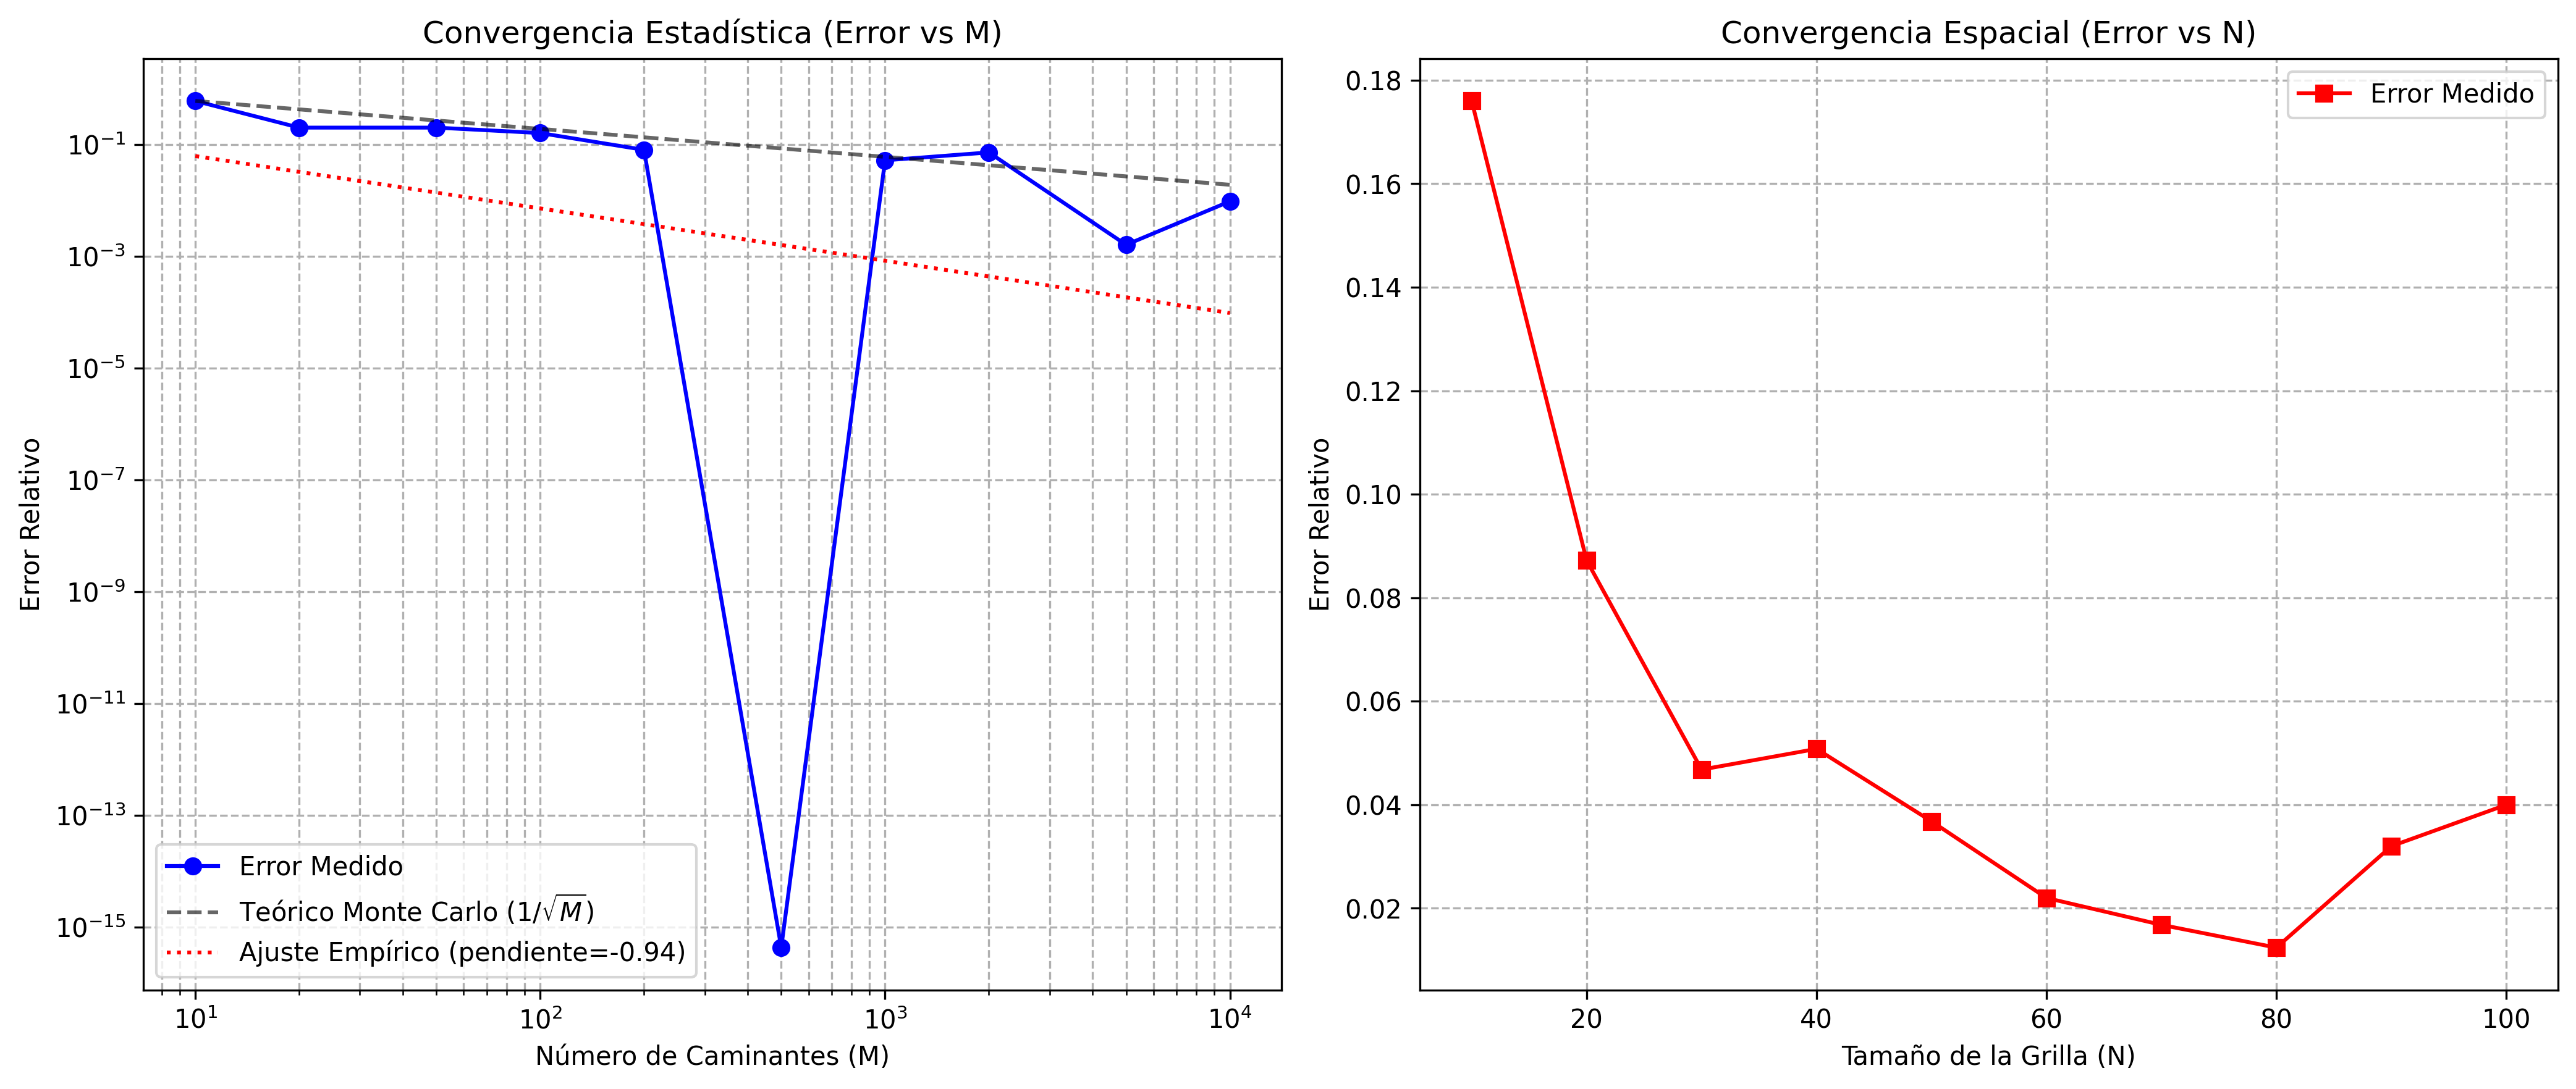

In [16]:
M_values, errores_M, N_values, errores_N = error_analysis()

# Graficar Resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Error vs M
# Teoría: El error de Monte Carlo decae como 1/sqrt(M)
ax1.loglog(M_values, errores_M, 'o-', label='Error Medido', color='blue')

# Línea teórica de referencia (pendiente -0.5)
ref_M = [errores_M[0] * np.sqrt(M_values[0]) / np.sqrt(m) for m in M_values]
ax1.loglog(M_values, ref_M, 'k--', alpha=0.6, label=r'Teórico Monte Carlo ($1/\sqrt{M}$)')
ajuste_M = np.polyfit(np.log(M_values), np.log(errores_M), 1)
pendiente_M = ajuste_M[0]
print(f"Pendiente ajustada (Error vs M): {pendiente_M:.4f} (Teórico: -0.5)")
ax1.loglog(M_values, np.exp(ajuste_M[1]) * np.array(M_values)**pendiente_M, 'r:', label=f'Ajuste Empírico (pendiente={pendiente_M:.2f})')

ax1.set_xlabel('Número de Caminantes (M)')
ax1.set_ylabel('Error Relativo')
ax1.set_title('Convergencia Estadística (Error vs M)')
ax1.grid(True, which="both", ls="--")
ax1.legend()

# Error vs N
# Teoría: Error de discretización espacial
ax2.plot(N_values, errores_N, 's-', color='red', label='Error Medido')
ax2.set_xlabel('Tamaño de la Grilla (N)')
ax2.set_ylabel('Error Relativo')
ax2.set_title('Convergencia Espacial (Error vs N)')
ax2.grid(True, ls="--")
ax2.legend()

plt.tight_layout()
plt.show();

## 2. Aceleración paralela

In [17]:
utils_path = os.path.abspath(os.path.join(os.getcwd(), 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

from simulacion_paralela import run_parallel_simulation

N_bench = 50
M_bench = 1_000

# Obtener el número máximo de núcleos disponibles en tu CPU
max_cores = mp.cpu_count()

# Definir los valores de p (núcleos) a probar: 1, 2, 4, ... hasta max_cores
p_values = [1]
while p_values[-1] * 2 <= max_cores:
    p_values.append(p_values[-1] * 2)
if p_values[-1] != max_cores:
    p_values.append(max_cores)

# Listas para guardar los resultados
times = []      # Tiempos de ejecución (T_p)
speedups = []   # Aceleración (S_p)
V_final = None  # Para guardar la matriz de potencial final (del caso más rápido)

print(f"Iniciando análisis de escalabilidad")
print(f"Grilla: {N_bench}x{N_bench}, Caminantes: {M_bench}\n")
print(f"{'Procesos (p)':<15} | {'Tiempo (s)':<15} | {'Speedup (S_p)':<15}")
print(f"----------------|-----------------|----------------")

# Bucle de ejecución
T_1 = None # Tiempo serial base

for p in p_values:
    # Llamamos a tu función importada.
    # run_parallel_simulation devuelve (V_matriz, tiempo_ejecucion)
    V_p, t_p = run_parallel_simulation(N_bench, M_bench, p)
    
    # Guardamos el tiempo
    times.append(t_p)
    
    # Calculamos Speedup
    if p == 1:
        T_1 = t_p
        s_p = 1.0
    else:
        s_p = T_1 / t_p
    
    speedups.append(s_p)
    
    # Guardamos la matriz resultante (puedes guardar solo la última o todas en un dict)
    V_final = V_p
    
    print(f"{p:<15} | {t_p:<15.4f} | {s_p:<15.2f}")

print("\nAnálisis completado.")

Iniciando análisis de escalabilidad
Grilla: 50x50, Caminantes: 1000

Procesos (p)    | Tiempo (s)      | Speedup (S_p)  
----------------|-----------------|----------------
1               | 184.9782        | 1.00           
2               | 96.6157         | 1.91           
4               | 50.7891         | 3.64           
8               | 32.3796         | 5.71           
16              | 29.4165         | 6.29           

Análisis completado.


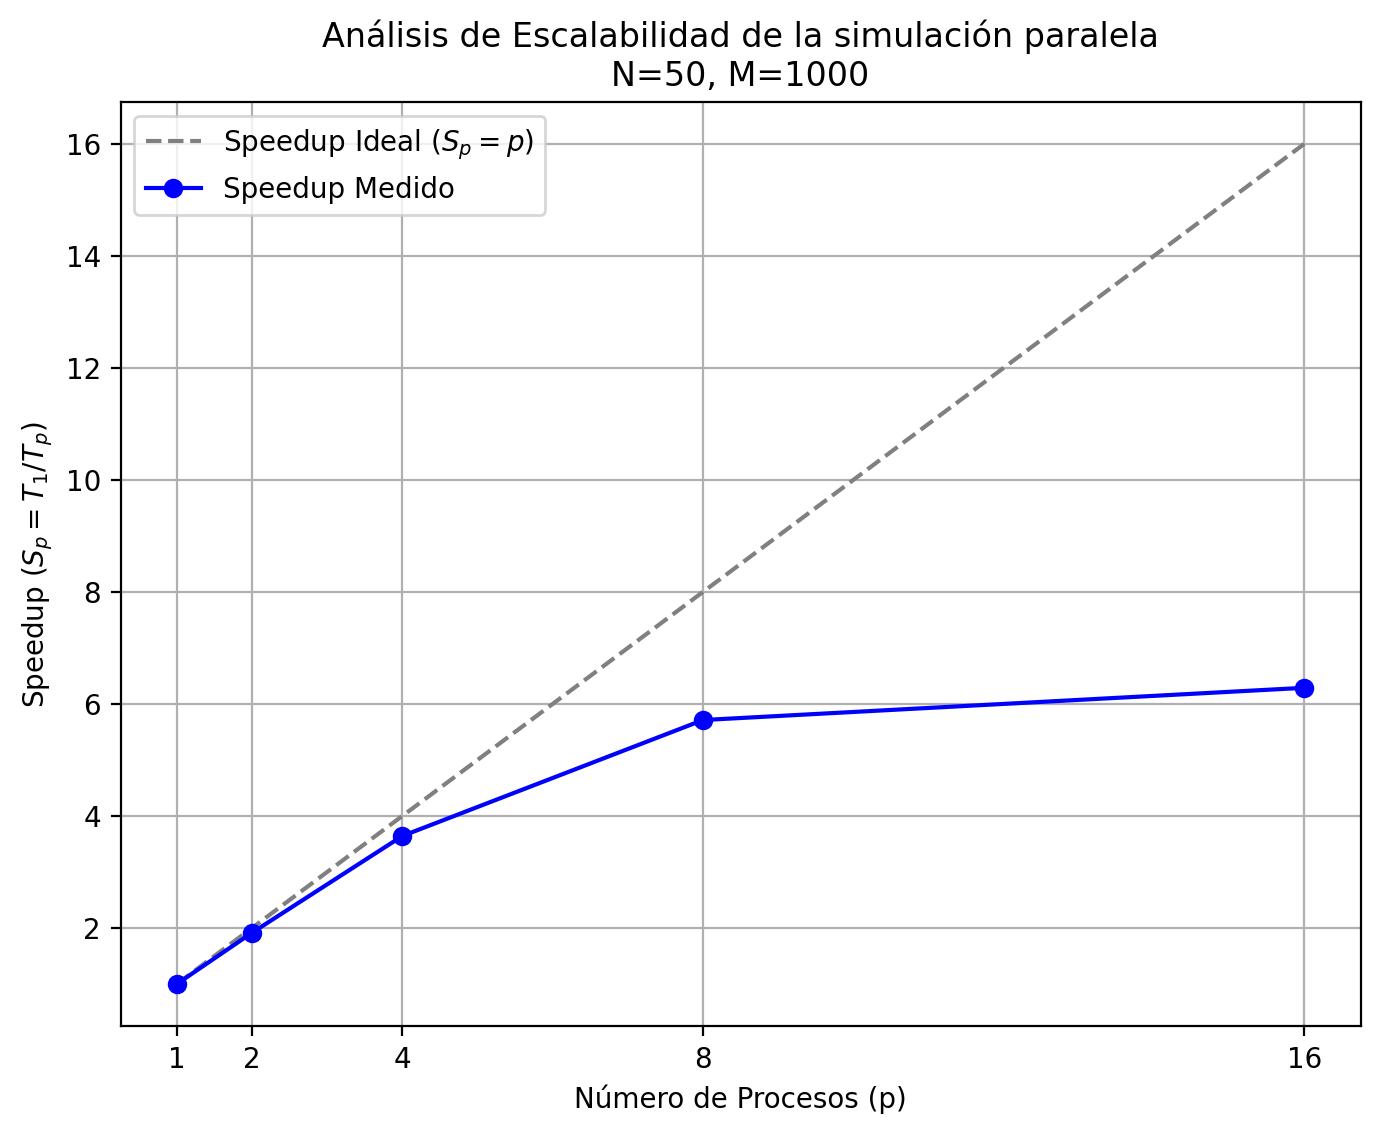

In [18]:
plt.figure(figsize=(8, 6))

# Curva ideal (lineal)
plt.plot(p_values, p_values, '--', color='gray', label=r'Speedup Ideal ($S_p = p$)')

# Curva medida
plt.plot(p_values, speedups, 'o-', label='Speedup Medido', color='blue')

plt.xticks(p_values)
plt.xlabel('Número de Procesos (p)')
plt.ylabel(r'Speedup ($S_p = T_1 / T_p$)')
plt.title(f'Análisis de Escalabilidad de la simulación paralela\nN={N_bench}, M={M_bench}')
plt.grid(True)
plt.legend()
plt.show()

## 3. Análisis espectral

## 4. Referencias